In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn # Paquete base de ML

from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

%matplotlib inline

df = pd.read_csv("diabetes.csv", delimiter = ',')
print(f"Observaciones : {df.shape[0]:,}")
print(f"Columnas      : {df.shape[1]}")
df.head()

Observaciones : 100,000
Columnas      : 9


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


No hay nulos en nuestro dataset

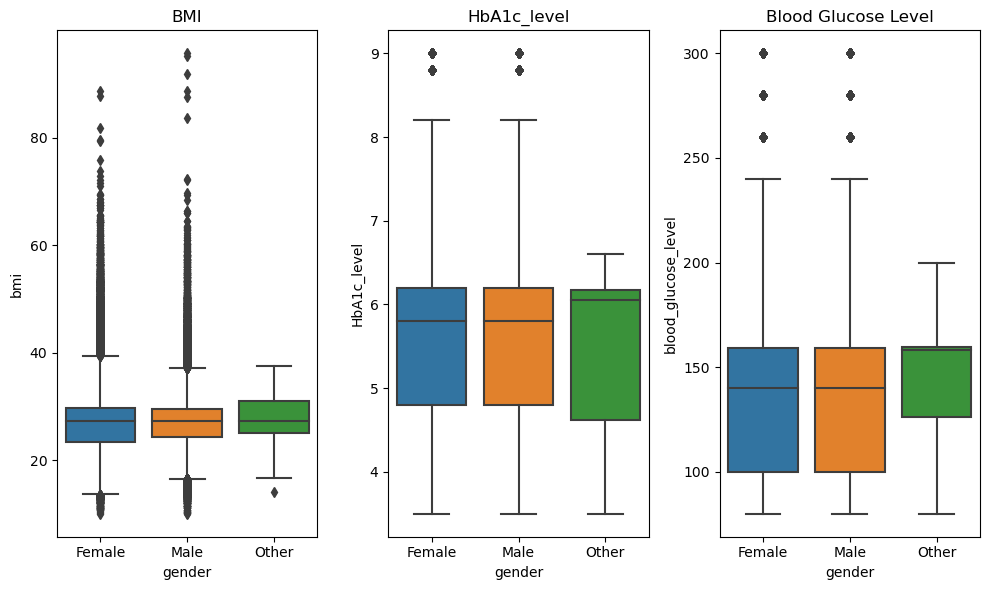

In [4]:
# Graficar los diagramas de caja
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='gender', y='bmi', data=df)
plt.title('BMI')

plt.subplot(1, 3, 2)
sns.boxplot(x='gender', y='HbA1c_level', data=df)
plt.title('HbA1c_level')

plt.subplot(1, 3, 3)
sns.boxplot(x='gender', y='blood_glucose_level', data=df)
plt.title('Blood Glucose Level')

plt.tight_layout()
plt.show()

Notamos que nuestra variable bmi posee outliers a considerar, por lo que aplicamos IQR para eliminar los extremos.

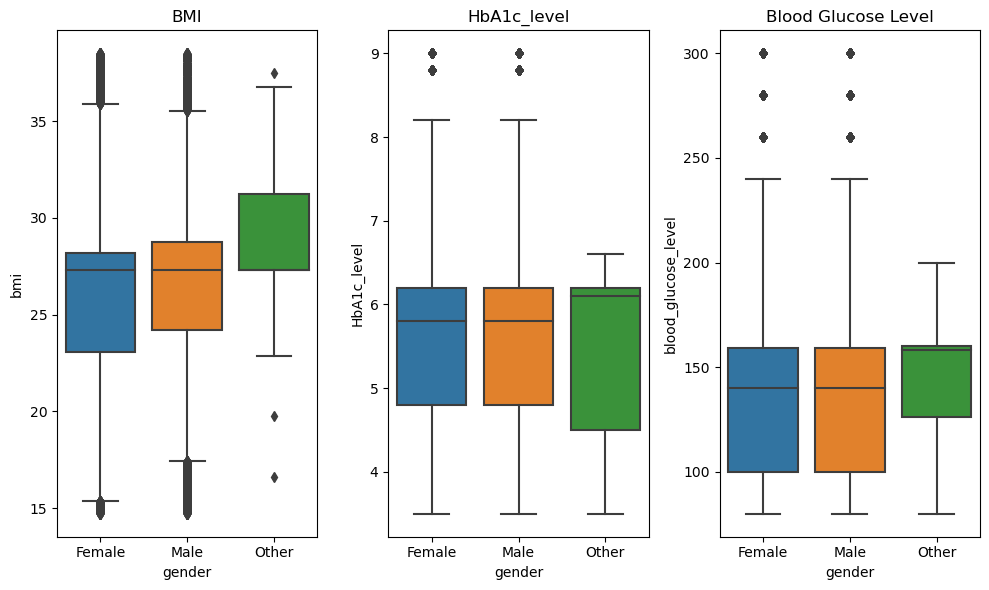

In [5]:
# Calcular Q1 y Q3
Q1 = df['bmi'].quantile(0.25)
Q3 = df['bmi'].quantile(0.75)

# Calcular IQR
IQR = Q3 - Q1

# Definir los límites inferior y superior para los outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar los datos y eliminar los outliers de la variable BMI
df = df[(df['bmi'] >= limite_inferior) & (df['bmi'] <= limite_superior)]

# Ver los datos resultantes sin los outliers

# Graficar los diagramas de caja
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='gender', y='bmi', data=df)
plt.title('BMI')

plt.subplot(1, 3, 2)
sns.boxplot(x='gender', y='HbA1c_level', data=df)
plt.title('HbA1c_level')

plt.subplot(1, 3, 3)
sns.boxplot(x='gender', y='blood_glucose_level', data=df)
plt.title('Blood Glucose Level')

plt.tight_layout()
plt.show()

Eliminamos outliers con IQR

In [6]:
# Crear una función para asignar categorías basadas en age
def categorize_age(age):
    if age < 30:
        return "joven"
    elif age < 60:
        return "adulto"
    else:
        return "anciano"
    
# Aplicar la función a la columna age y crear una nueva columna age_group
df['age_group'] = df['age'].apply(categorize_age)

# Mostrar el resultado
print(df[['age', 'age_group']])


        age age_group
0      80.0   anciano
1      54.0    adulto
2      28.0     joven
3      36.0    adulto
4      76.0   anciano
...     ...       ...
99995  80.0   anciano
99996   2.0     joven
99997  66.0   anciano
99998  24.0     joven
99999  57.0    adulto

[92914 rows x 2 columns]


Para especificar aun mas los rangos de edades, separamos nuestros datos en 3. Para menores de 30 usaremos la etiqueta 'menor', entre 30 y 60 usamos la etiqueta 'adulto' y para mayores de 60 se usara la etiqueta 'anciano'.

In [7]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,age_group
0,Female,80.0,0,1,never,25.19,6.6,140,0,anciano
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,adulto
2,Male,28.0,0,0,never,27.32,5.7,158,0,joven
3,Female,36.0,0,0,current,23.45,5.0,155,0,adulto
4,Male,76.0,1,1,current,20.14,4.8,155,0,anciano


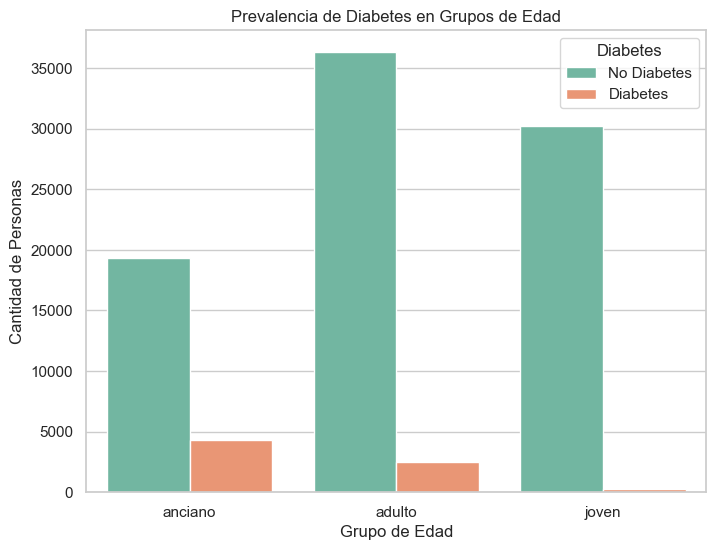

In [8]:
# Configurar el estilo del gráfico
sns.set(style="whitegrid")

# Crear un gráfico de barras
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='age_group', hue='diabetes', palette='Set2')

# Agregar etiquetas y título
plt.xlabel('Grupo de Edad')
plt.ylabel('Cantidad de Personas')
plt.title('Prevalencia de Diabetes en Grupos de Edad')
plt.legend(title='Diabetes', labels=['No Diabetes', 'Diabetes'])

# Mostrar el gráfico
plt.show()

Se puede observar una mayor cantidad de personas con Diabetes en el grupo 'anciano'

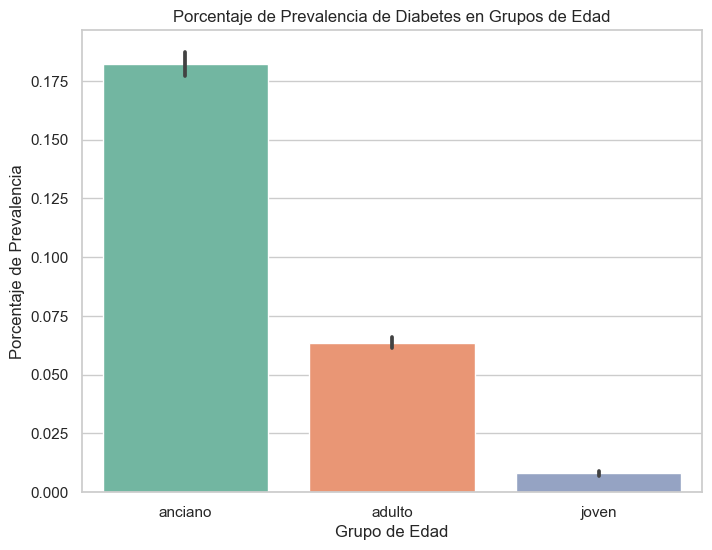

In [9]:
# Calcular los porcentajes de prevalencia de diabetes en cada grupo de edad
prevalence_percentages = df.groupby('age_group')['diabetes'].mean() * 100

# Configurar el estilo del gráfico
sns.set(style="whitegrid")

# Crear un gráfico de barras agrupado
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df, x='age_group', y='diabetes', palette='Set2')

# Agregar etiquetas y título
plt.xlabel('Grupo de Edad')
plt.ylabel('Porcentaje de Prevalencia')
plt.title('Porcentaje de Prevalencia de Diabetes en Grupos de Edad')

# Mostrar el gráfico
plt.show()

Vemos que el grupo 'anciano' tiene el mayor porcentaje de prevalencia de Diabetes con mas de 17.5% comparado con los otos grupos que poseen porcentajes menores.

In [10]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,92914.000000,92914.00000,92914.000000,92914.000000,92914.000000,92914.000000,92914.000000
mean,41.966506,0.07028,0.039068,26.400779,5.514219,137.495426,0.075575
std,22.628538,0.25562,0.193759,4.892598,1.061857,40.080111,0.264319
min,0.080000,0.00000,0.000000,14.710000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.480000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,28.440000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,38.500000,9.000000,300.000000,1.000000


Inferencia

1. Columnas 'hypertension', 'heart_disease' y 'diabetes' poseen valores entre 0 y 1 por lo que son consideradas como variables binarias.
2. 'age' parte desde 0.08 años hasta 80 años, con una media de 41,9.
3. La columna Diabetes indica que un 7,6 % del total padece diabetes contra un total de 92,4 que no la padece.

In [11]:
count_diabetes = df['diabetes'].value_counts()

print(count_diabetes)

0    85892
1     7022
Name: diabetes, dtype: int64


In [12]:
# Calcular los porcentajes de 1 y 0 en la columna diabetes
percentage_diabetes = df['diabetes'].value_counts(normalize=True) * 100

print(percentage_diabetes)

0    92.442474
1     7.557526
Name: diabetes, dtype: float64


In [13]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Crear una copia del DataFrame original
df_resampled = df.copy()

# Convertir las columnas categóricas a variables numéricas utilizando LabelEncoder
label_encoder = LabelEncoder()
for column in ['gender', 'smoking_history', 'age_group']:
    df_resampled[column] = label_encoder.fit_transform(df_resampled[column])

# Dividir el DataFrame en características (X) y etiquetas (y)
X = df_resampled.drop('diabetes', axis=1)
y = df_resampled['diabetes']

# Aplicar Sobremuestreo con SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Crear un DataFrame a partir de X_resampled
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)

# Aplicar one-hot encoding a las variables categóricas en X_resampled_df
X_resampled_encoded = pd.get_dummies(X_resampled_df, columns=['gender', 'smoking_history', 'age_group'], drop_first=True)

In [35]:
X_resampled_df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,age_group
0,0,80.0,0,1,4,25.19,6.6,140,1
1,0,54.0,0,0,0,27.32,6.6,80,0
2,1,28.0,0,0,4,27.32,5.7,158,2
3,0,36.0,0,0,1,23.45,5.0,155,0
4,1,76.0,1,1,1,20.14,4.8,155,1


Aplicamos oversampling y one hot dummies para probar modelos de ML y ver si es optimo correrlos con el dataframe balanceado.

In [14]:
# Aplicar one-hot encoding a las columnas categóricas
df_encoded = pd.get_dummies(df, columns=['gender', 'smoking_history', 'age_group'])

df_encoded.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,age_group_adulto,age_group_anciano,age_group_joven
0,80.0,0,1,25.19,6.6,140,0,1,0,0,0,0,0,0,1,0,0,1,0
1,54.0,0,0,27.32,6.6,80,0,1,0,0,1,0,0,0,0,0,1,0,0
2,28.0,0,0,27.32,5.7,158,0,0,1,0,0,0,0,0,1,0,0,0,1
3,36.0,0,0,23.45,5.0,155,0,1,0,0,0,1,0,0,0,0,1,0,0
4,76.0,1,1,20.14,4.8,155,0,0,1,0,0,1,0,0,0,0,0,1,0


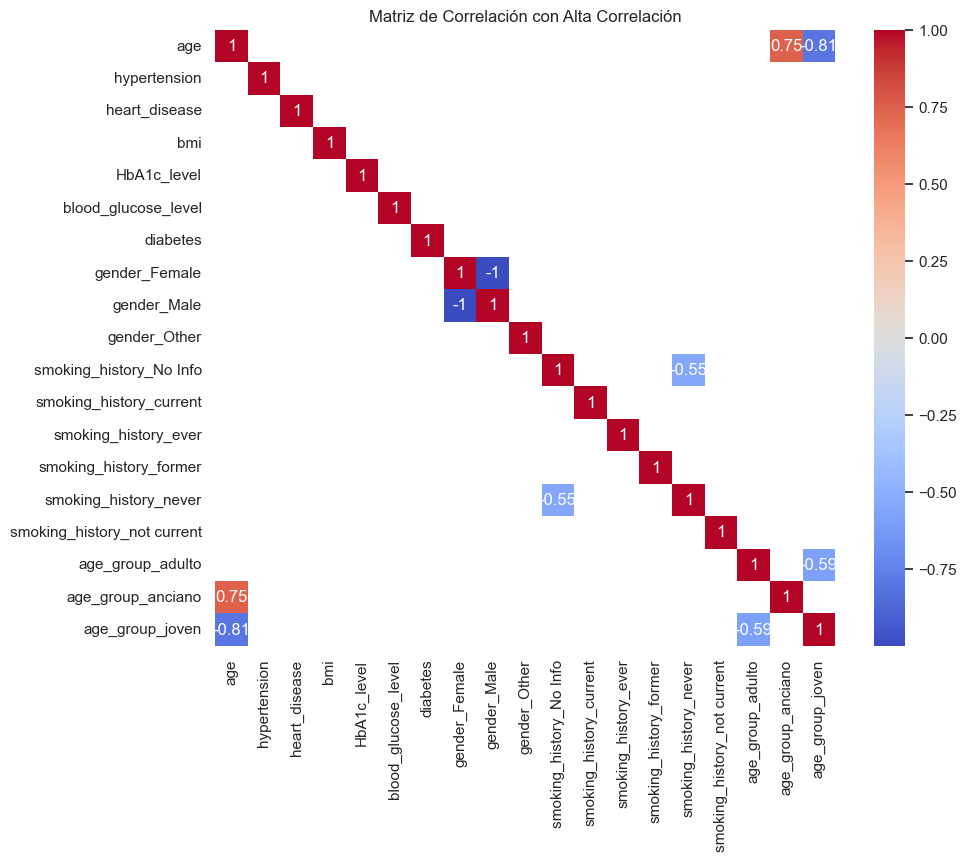

In [15]:
# Calcular la matriz de correlación
correlation_matrix = df_encoded.corr()

# Definir un umbral de correlación (por ejemplo, 0.5)
high_correlation_threshold = 0.5

# Filtrar la matriz de correlación para mostrar solo las variables con alta correlación
high_correlation_matrix = correlation_matrix[
    (correlation_matrix > high_correlation_threshold) |
    (correlation_matrix < -high_correlation_threshold)
]

# Configurar el estilo del gráfico
sns.set(style="white")

# Crear el mapa de calor para la matriz de correlación con alta correlación
plt.figure(figsize=(10, 8))
sns.heatmap(high_correlation_matrix, annot=True, cmap="coolwarm", center=0)

# Agregar título
plt.title("Matriz de Correlación con Alta Correlación")

# Mostrar el gráfico
plt.show()

In [16]:
# Eliminar la columna age_group_anciano
df_encoded = df_encoded.drop(columns=['age_group_anciano'])

Eliminamos la columna 'age_group_anciano' por su alta correlación con la columna'age'.

In [22]:
df_encoded.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,age_group_adulto,age_group_joven
0,80.0,0,1,25.19,6.6,140,0,1,0,0,0,0,0,0,1,0,0,0
1,54.0,0,0,27.32,6.6,80,0,1,0,0,1,0,0,0,0,0,1,0
2,28.0,0,0,27.32,5.7,158,0,0,1,0,0,0,0,0,1,0,0,1
3,36.0,0,0,23.45,5.0,155,0,1,0,0,0,1,0,0,0,0,1,0
4,76.0,1,1,20.14,4.8,155,0,0,1,0,0,1,0,0,0,0,0,0


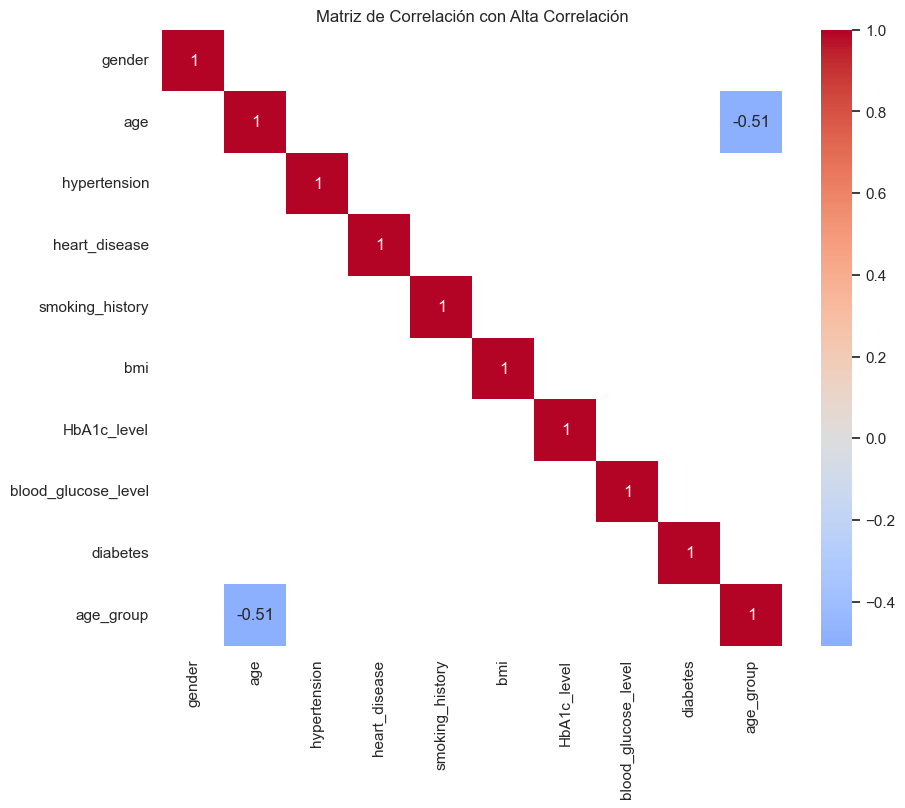

In [17]:
# Calcular la matriz de correlación
correlation_matrix = df_resampled.corr()

# Definir un umbral de correlación (por ejemplo, 0.5)
high_correlation_threshold = 0.5

# Filtrar la matriz de correlación para mostrar solo las variables con alta correlación
high_correlation_matrix = correlation_matrix[
    (correlation_matrix > high_correlation_threshold) |
    (correlation_matrix < -high_correlation_threshold)
]

# Configurar el estilo del gráfico
sns.set(style="white")

# Crear el mapa de calor para la matriz de correlación con alta correlación
plt.figure(figsize=(10, 8))
sns.heatmap(high_correlation_matrix, annot=True, cmap="coolwarm", center=0)

# Agregar título
plt.title("Matriz de Correlación con Alta Correlación")

# Mostrar el gráfico
plt.show()

No se observan correlaciones a considerar para eliminar alguna variable.

In [23]:
from sklearn.model_selection import train_test_split

# Separar las características (X) y la variable objetivo (y)
X = df_encoded.drop(columns=['diabetes'])  # Características
y = df_encoded['diabetes']  # Variable objetivo

# Dividir el conjunto de datos original en entrenamiento (70%), prueba (15%) y validación (15%)
X_train_orig, X_temp_orig, y_train_orig, y_temp_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_val_orig, X_test_orig, y_val_orig, y_test_orig = train_test_split(X_temp_orig, y_temp_orig, test_size=0.5, random_state=42)

# Dividir el conjunto de datos con oversampling en entrenamiento (70%) y prueba (30%)
X_train_temp, X_test_resampled, y_train_temp, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Dividir el conjunto temporal en conjunto de entrenamiento (50%) y conjunto de validación (50%)
X_train_resampled, X_val_resampled, y_train_resampled, y_val_resampled = train_test_split(X_train_temp, y_train_temp, test_size=0.5, random_state=42)

# Imprimir las formas de los conjuntos de datos resultantes
print("Forma de los conjuntos de datos originales:")
print("X_train_orig:", X_train_orig.shape)
print("X_val_orig:", X_val_orig.shape)
print("X_test_orig:", X_test_orig.shape)

print("\nForma de los conjuntos de datos con oversampling:")
print("X_train_resampled:", X_train_resampled.shape)
print("X_val_resampled:", X_val_resampled.shape)
print("X_test_resampled:", X_test_resampled.shape)

Forma de los conjuntos de datos originales:
X_train_orig: (65039, 17)
X_val_orig: (13937, 17)
X_test_orig: (13938, 17)

Forma de los conjuntos de datos con oversampling:
X_train_resampled: (60124, 9)
X_val_resampled: (60124, 9)
X_test_resampled: (51536, 9)


Separamos nuestros dos dataframe (uno con oversampling y otro normal), en datos de train, test y validación.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Definir los modelos a evaluar
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Definir los conjuntos de datos a evaluar
datasets = {
    'Original Dataset': (X_train_orig, y_train_orig, X_val_orig, y_val_orig, X_test_orig, y_test_orig),
    'Oversampled Dataset': (X_train_temp, y_train_temp, X_val_resampled, y_val_resampled, X_test_resampled, y_test_resampled)
}

# Evaluar los modelos en cada conjunto de datos
for dataset_name, (X_train, y_train, X_val, y_val, X_test, y_test) in datasets.items():
    print(f"{'='*40}\nConjunto de Datos: {dataset_name}\n{'='*40}")
    
    for model_name, model in models.items():
        print(f"Modelo: {model_name}")
        
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Predecir en el conjunto de validación
        y_pred_val = model.predict(X_val)
        
        # Calcular métricas en el conjunto de validación
        accuracy_val = accuracy_score(y_val, y_pred_val)
        precision_val = precision_score(y_val, y_pred_val)
        recall_val = recall_score(y_val, y_pred_val)
        f1_val = f1_score(y_val, y_pred_val)
        roc_auc_val = roc_auc_score(y_val, y_pred_val)
        conf_matrix_val = confusion_matrix(y_val, y_pred_val)
        report_val = classification_report(y_val, y_pred_val)
        
        # Predecir en el conjunto de pruebas
        y_pred_test = model.predict(X_test)
        
        # Calcular métricas en el conjunto de pruebas
        accuracy_test = accuracy_score(y_test, y_pred_test)
        precision_test = precision_score(y_test, y_pred_test)
        recall_test = recall_score(y_test, y_pred_test)
        f1_test = f1_score(y_test, y_pred_test)
        roc_auc_test = roc_auc_score(y_test, y_pred_test)
        conf_matrix_test = confusion_matrix(y_test, y_pred_test)
        report_test = classification_report(y_test, y_pred_test)

        # Imprimir métricas para validación y prueba
        print("Métricas para Validación:")
        print("Exactitud:", accuracy_val)
        print("Precisión:", precision_val)
        print("Recall:", recall_val)
        print("F1-Score:", f1_val)
        print("Área bajo la curva ROC:", roc_auc_val)
        print("Matriz de Confusión:\n", conf_matrix_val)
        print("Informe de Clasificación:\n", report_val)

        print("\nMétricas para Prueba:")
        print("Exactitud:", accuracy_test)
        print("Precisión:", precision_test)
        print("Recall:", recall_test)
        print("F1-Score:", f1_test)
        print("Área bajo la curva ROC:", roc_auc_test)
        print("Matriz de Confusión:\n", conf_matrix_test)
        print("Informe de Clasificación:\n", report_test)
        
        print('='*40)

Conjunto de Datos: Original Dataset
Modelo: Random Forest
Métricas para Validación:
Exactitud: 0.9737389682141063
Precisión: 0.9536784741144414
Recall: 0.6782945736434108
F1-Score: 0.7927519818799547
Área bajo la curva ROC: 0.8378299679530498
Matriz de Confusión:
 [[12871    34]
 [  332   700]]
Informe de Clasificación:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     12905
           1       0.95      0.68      0.79      1032

    accuracy                           0.97     13937
   macro avg       0.96      0.84      0.89     13937
weighted avg       0.97      0.97      0.97     13937


Métricas para Prueba:
Exactitud: 0.9731668819055819
Precisión: 0.9389110225763613
Recall: 0.6830917874396135
F1-Score: 0.79082774049217
Área bajo la curva ROC: 0.8397633625255109
Matriz de Confusión:
 [[12857    46]
 [  328   707]]
Informe de Clasificación:
               precision    recall  f1-score   support

           0       0.98      1.00  

Definimos una formula para probar varios modelos y en base a la metricas obtenidas el modelo que destaca es el Random Forest. En nuestro conjunto con oversampling, tiene un rendimiento excelente en todas las métricas, incluido un F1-score de 0.9994, lo que sugiere que está logrando un equilibrio casi perfecto entre precisión y recall en ambos grupos.

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Definir los valores a explorar para 'n_estimators' y 'max_depth'
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20]
}

# Crear un modelo base de RandomForest
base_model = RandomForestClassifier(random_state=42)

# Crear el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(
    base_model, param_distributions=param_dist,
    n_iter=10, cv=5, scoring='f1', verbose=2, n_jobs=-1, random_state=42
)

# Realizar la búsqueda en el conjunto de entrenamiento con oversampling
random_search.fit(X_train_resampled, y_train_resampled)

# Obtener los mejores hiperparámetros y el mejor modelo
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Mejores hiperparámetros:", best_params)
print("Mejor modelo:", best_model)

C:\Users\Alondra\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Mejores hiperparámetros: {'n_estimators': 300, 'max_depth': None}
Mejor modelo: RandomForestClassifier(n_estimators=300, random_state=42)


Optimización de Modelo con RandomizedSearchCV

Realizamos una búsqueda automática de los mejores ajustes para nuestro modelo de Random Forest utilizando RandomizedSearchCV. Los valores óptimos encontrados son 300 estimadores y sin límite de profundidad. Con estos ajustes, esperamos que nuestro modelo sea preciso y capaz de identificar casos de diabetes de manera efectiva.

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Preprocesamiento de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicación de PCA
pca = PCA(n_components=0.95)  # Conservar el 95% de la varianza
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Entrenamiento y evaluación de modelos con PCA
model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train_pca, y_train)

# Evaluación en el conjunto de prueba
y_pred = model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Exactitud:", accuracy)
print("F1-Score:", f1)

Exactitud: 0.9389941012108041
F1-Score: 0.9399174438159302


Al aplicar PCA al modelo de Random Forest, se obtuvo una buena precisión de alrededor del 94% y un F1-Score cercano al 94%. Esto sugiere que PCA ayudó a mejorar la capacidad de clasificación y generalización del modelo en los datos de prueba.

In [37]:
# Aplicar one-hot encoding a las variables categóricas en X_val_resampled
X_val_resampled_encoded = pd.get_dummies(X_val_resampled, columns=['gender', 'smoking_history', 'age_group'], drop_first=True)

# Aplicar PCA con 95% de varianza en el conjunto con oversampling
pca = PCA(n_components=0.95, random_state=42)
X_train_resampled_pca = pca.fit_transform(X_train_resampled)
X_val_resampled_pca = pca.transform(X_val_resampled_encoded)

# Entrenar un modelo RandomForestClassifier en el conjunto con PCA
model_with_pca = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42)
model_with_pca.fit(X_train_resampled_pca, y_train_resampled)

# Predecir en el conjunto de validación
y_pred_val = model_with_pca.predict(X_val_resampled_pca)

# Calcular métricas
accuracy_val = accuracy_score(y_val_resampled, y_pred_val)
f1_val = f1_score(y_val_resampled, y_pred_val)

print("Exactitud en Validación:", accuracy_val)
print("F1-Score en Validación:", f1_val)

Exactitud en Validación: 0.9659037988157807
F1-Score en Validación: 0.9660078264906812


Al aplicar PCA en el conjunto de validación con oversampling, hemos logrado aumentar la exactitud a un impresionante 96.59% y el F1-Score a 0.966. Esta combinación de técnicas demuestra su efectividad en mejorar la precisión de la clasificación de casos de diabetes.

In [41]:
# Obtener los coeficientes de las variables en los dos primeros componentes principales
component_loadings = pca.components_[:2]

# Crear un DataFrame para visualizar las cargas de las variables en los componentes
component_loading_df = pd.DataFrame(component_loadings, columns=X_resampled_encoded.columns)

# Calcular la proporción de la varianza explicada por cada variable en los dos primeros componentes
explained_variance_ratio = pca.explained_variance_ratio_[:2]

# Calcular las proporciones de la varianza explicada por las variables en porcentaje
explained_variance_ratio_percent = component_loading_df.apply(lambda col: col.abs() * explained_variance_ratio * 100)

# Mostrar las proporciones de la varianza explicada por las variables en porcentaje
print("Proporciones de la Varianza Explicada por Variables (en %) en el Primer Componente Principal:")
print(explained_variance_ratio_percent.iloc[0].sort_values(ascending=False))

print("\nProporciones de la Varianza Explicada por Variables (en %) en el Segundo Componente Principal:")
print(explained_variance_ratio_percent.iloc[1].sort_values(ascending=False))


Proporciones de la Varianza Explicada por Variables (en %) en el Primer Componente Principal:
blood_glucose_level    87.029329
age                    10.554107
bmi                     1.494476
HbA1c_level             0.629172
age_group_1             0.187829
age_group_2             0.154801
smoking_history_3       0.074877
gender_1                0.040361
smoking_history_5       0.017243
hypertension            0.012323
smoking_history_2       0.012255
heart_disease           0.008339
smoking_history_1       0.001963
smoking_history_4       0.000309
gender_2                0.000035
Name: 0, dtype: float64

Proporciones de la Varianza Explicada por Variables (en %) en el Segundo Componente Principal:
age                    11.597294
blood_glucose_level     1.422869
bmi                     0.853807
age_group_1             0.202837
age_group_2             0.164990
HbA1c_level             0.139978
smoking_history_3       0.045800
hypertension            0.025058
heart_disease           0.0

La aplicación de PCA redujo la complejidad de los datos manteniendo el 95% de la información clave. En los dos primeros componentes, "glucose_level" y "bmi" tienen un impacto principal en la variación. Estas variables podrían ser esenciales para distinguir patrones en los datos.